# Trajectory Generation with Fixed-k Privacy Protection

This notebook implements experiments for generating and evaluating privacy-protected trajectories using a GRU-based model with a fixed-k approach. It loads the pre-trained models and test data for the Porto and San Francisco datasets, generates protected trajectories for different values of k, and evaluates the results by computing point-to-point distances (MDE) between real and protected trajectories. 

The computed MDE_k values are used for setting up the adaptive k approach.

##### **Imports**

In [1]:
import os
# oneDNN warning suppression TF 2.4.1
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import copy

import numpy as np
import pandas as pd
import pickle
import statistics

from scipy.stats import energy_distance, wasserstein_distance
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from math import radians
from sklearn.metrics.pairwise import haversine_distances

from utils.data import *
from utils.plots import *
from utils.metrics import *
from models import *
from apu_trajgen import *

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

## **Experiments**

#### **Load Data (Porto dataset)** 

In [2]:
# Load the model generated by the training script from the 'training' folder
selected_dataset = "PORTO"

subset = "test" # or "train" 

# Load trajectory data for faster execution
data = load_data_from_pickle(DATASET[selected_dataset], TOTAL_TRAJS)

# Get the data in the selected square
data = get_data_in_square(data = data, square = DATA_SQUARE[selected_dataset])

# Get trajectories min and max values
mins, maxs =  get_min_max_from_data(data)

# Normalize the data using the min and max values
normalization_ranges = {"min": mins, "max": maxs}

# Get number of trajectories
num_of_traj = len(data)

# Only keep the lat and lon columns for now
data = [data[i][COLUMNS] for i in range(num_of_traj)]

# Normalize the data using scaler or normalization ranges
scaler, data = normalize_trajectory_data(dataset = data, normalization_type = 'min-max')

# Load the test data
X_t = load_pickle(DATA_FOLDER + selected_dataset.lower() + "_X_"+subset+".pkl") # the input trajectory data
Y_t = load_pickle(DATA_FOLDER + selected_dataset.lower() + "_Y_"+subset+".pkl") # the true values of the trajectory data
traj_seq_lengths = load_pickle(DATA_FOLDER + selected_dataset.lower() + "_seq_len_"+subset+".pkl") # the sequence lenght of the input trajectory data



#### **Load Model** 

In [ ]:
# Load the pre-trained model
mdl = load_pickle(MODEL_FOLDER + "mdlgru-"+selected_dataset.lower()+".pkl")

# Create the model for generating trajectories with BS = 1
model_sl = create_GRU_model(GRU_cells= LSTM_CELLS,
                          seq_len = 1,
                          num_feat = NUM_FEATS,
                          batch_size = 1,
                          stateful = True,
                          return_seq = RETURN_SEQ,
                          num_outputs = NUM_OUTPUTS,
                          LR = LR,
                          SEED = SEED,
                          ragged = False)


# Load the weights and states from the pre-trained model
model_sl.set_weights(mdl.get_weights())

#### **Experiment 1 (Porto dataset) - Fixed k -** 

In [4]:
# Set the number of trajectories to generate/protect
n_trajs = 10

In [ ]:
Y_PREDS_Ks = {}

save_pickle(Y_t[:n_trajs], DATA_FOLDER + selected_dataset.lower() + "_Y_test_fixed_k_ntrajs_" + str(n_trajs) + ".pkl")
save_pickle(traj_seq_lengths[:n_trajs], DATA_FOLDER + selected_dataset.lower() + "_test_seq_len_fixed_k_ntrajs_" + str(n_trajs) + ".pkl")

for k in range(1, 6):
    print("Generating trajectories with k = " + str(k))
    
    # Generate the trajectories using the APU Trajectory Generator with fixed k
    # The function apu_trajgen_fixed_k generates trajectories with a fixed k value
    # It uses the model_sl, input trajectory data X_t, sequence lengths traj_seq_lengths,
    # and other parameters to generate the trajectories.
    Y_pred_k = apu_trajgen_fixed_k(mdl = model_sl,
                                X_t = copy.deepcopy(X_t)[:n_trajs],
                                test_traj_seq_lengths = traj_seq_lengths,
                                SEQ_LENGTH = 1,
                                NUM_FEATS = NUM_FEATS,
                                k_steps=k)
    
    
    save_pickle(Y_pred_k, DATA_FOLDER + selected_dataset.lower() + "_Y_pred_fixed_k_" + str(k) + "_ntrajs_" + str(n_trajs) + ".pkl")
    
    Y_PREDS_Ks[k] = Y_pred_k

Generating trajectories with k = 1
Processing trajectory: 0
Processing trajectory: 1
Processing trajectory: 2
Processing trajectory: 3
Processing trajectory: 4
Processing trajectory: 5
Processing trajectory: 6
Processing trajectory: 7
Processing trajectory: 8
Processing trajectory: 9
Generating trajectories with k = 2
Processing trajectory: 0
Processing trajectory: 1
Processing trajectory: 2
Processing trajectory: 3
Processing trajectory: 4
Processing trajectory: 5
Processing trajectory: 6
Processing trajectory: 7
Processing trajectory: 8
Processing trajectory: 9
Generating trajectories with k = 3
Processing trajectory: 0
Processing trajectory: 1
Processing trajectory: 2
Processing trajectory: 3
Processing trajectory: 4
Processing trajectory: 5
Processing trajectory: 6
Processing trajectory: 7
Processing trajectory: 8
Processing trajectory: 9
Generating trajectories with k = 4
Processing trajectory: 0
Processing trajectory: 1
Processing trajectory: 2
Processing trajectory: 3
Processing

#### **Plot a Trajectory** 

<Figure size 640x480 with 0 Axes>

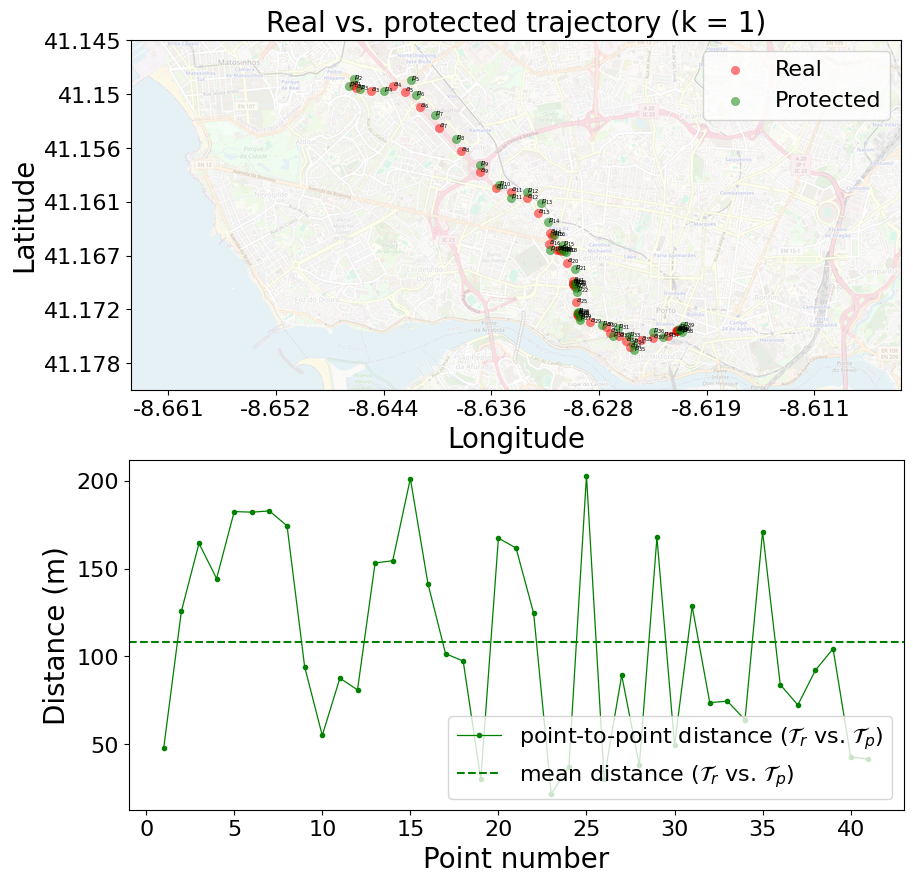

Point-to-point distance between the real and protected trajectory:
[np.float64(47.9700227941053), np.float64(125.630331347026), np.float64(164.3363985272153), np.float64(144.2908245258834), np.float64(182.418374804103), np.float64(182.09379014793333), np.float64(182.78433640230472), np.float64(174.27664971526636), np.float64(94.04981240358357), np.float64(54.99428588008252), np.float64(87.6056296123878), np.float64(80.92677686638184), np.float64(153.16638103701015), np.float64(154.45226170826933), np.float64(201.25053748112887), np.float64(141.36402560352087), np.float64(101.5229879753887), np.float64(97.36588171838633), np.float64(29.99998826321709), np.float64(167.31186079046776), np.float64(161.7007764341119), np.float64(124.56916510497808), np.float64(21.771143719005245), np.float64(36.98104755211208), np.float64(202.8838450273793), np.float64(30.462981223312354), np.float64(89.24004358206298), np.float64(37.93441435861744), np.float64(167.69572997867624), np.float64(49.45645109770

<Figure size 640x480 with 0 Axes>

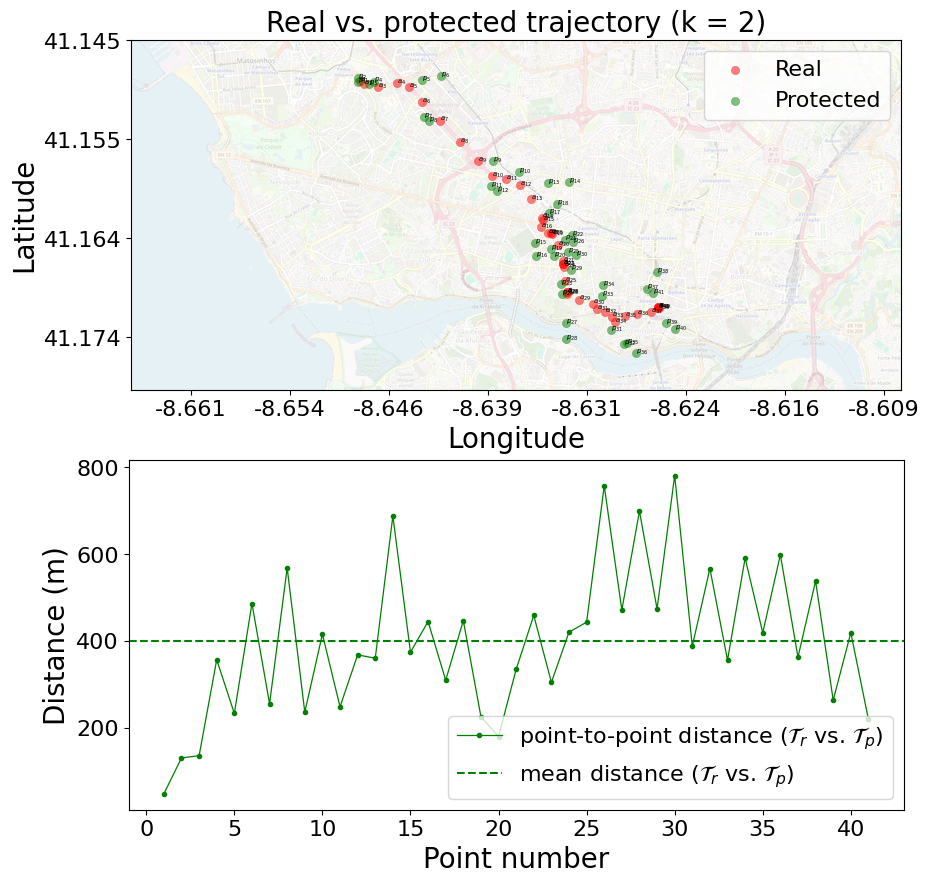

Point-to-point distance between the real and protected trajectory:
[np.float64(47.9700227941053), np.float64(130.64603067712085), np.float64(135.6370467149717), np.float64(356.5514477672994), np.float64(232.89713950828317), np.float64(485.88428180666415), np.float64(255.30878357950044), np.float64(567.7437814265814), np.float64(235.8568546299153), np.float64(415.38461795741813), np.float64(248.26756229081104), np.float64(367.6445845176838), np.float64(360.09338991498004), np.float64(687.246158060364), np.float64(373.82732819233104), np.float64(444.4070315971466), np.float64(309.3296188767446), np.float64(446.60600750678606), np.float64(225.55045300444723), np.float64(179.8573485410946), np.float64(334.4333084218682), np.float64(458.5255800876927), np.float64(304.3288920674094), np.float64(419.96112643022974), np.float64(443.05566760930094), np.float64(756.6916142628655), np.float64(470.9834770375365), np.float64(698.6100300155606), np.float64(473.46789265955346), np.float64(780.1927636

<Figure size 640x480 with 0 Axes>

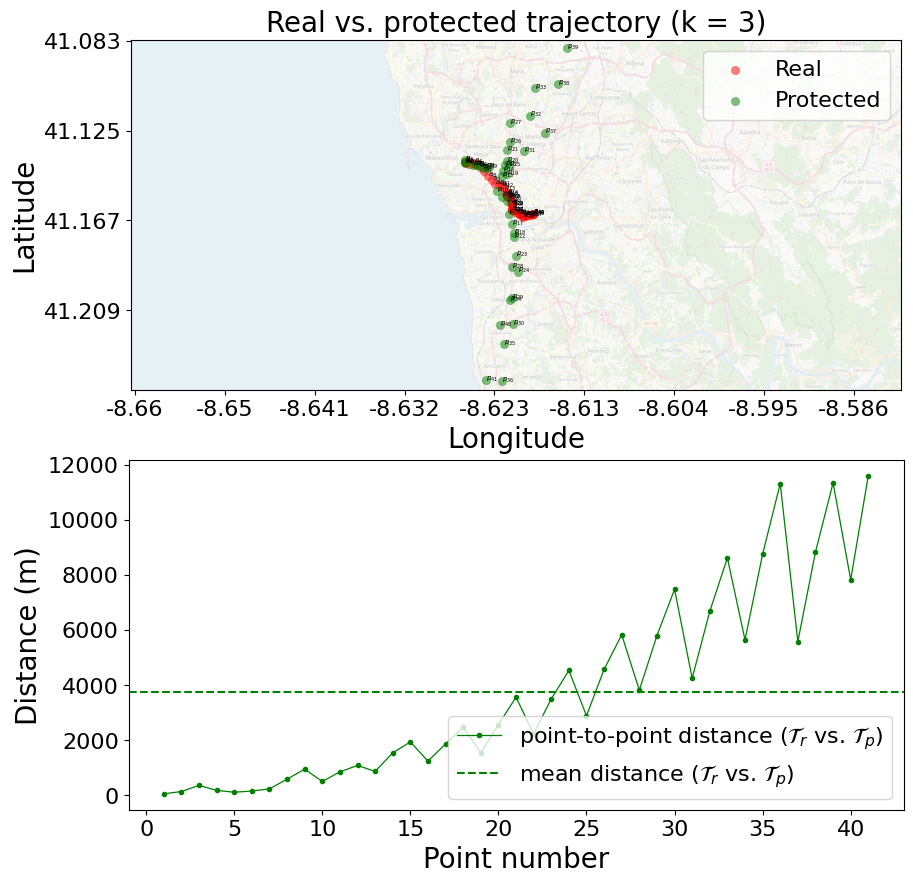

Point-to-point distance between the real and protected trajectory:
[np.float64(47.9700227941053), np.float64(130.64603067712085), np.float64(354.6063330768428), np.float64(173.12644754780285), np.float64(105.2559171394013), np.float64(148.8920988836859), np.float64(226.85018025862075), np.float64(581.5791803004622), np.float64(941.1086283964975), np.float64(496.8338380923726), np.float64(846.167999380449), np.float64(1077.8181991354297), np.float64(862.172269191484), np.float64(1534.845491550752), np.float64(1933.1532761851179), np.float64(1233.6745805780415), np.float64(1862.676513134669), np.float64(2466.3610058648883), np.float64(1541.5339701072123), np.float64(2559.628813855763), np.float64(3555.7034359643285), np.float64(2225.3092824032974), np.float64(3492.773837670241), np.float64(4526.767772521689), np.float64(2880.1809384279527), np.float64(4567.208919033024), np.float64(5822.06486710036), np.float64(3811.73618330161), np.float64(5790.8625730091135), np.float64(7471.3478092191

<Figure size 640x480 with 0 Axes>

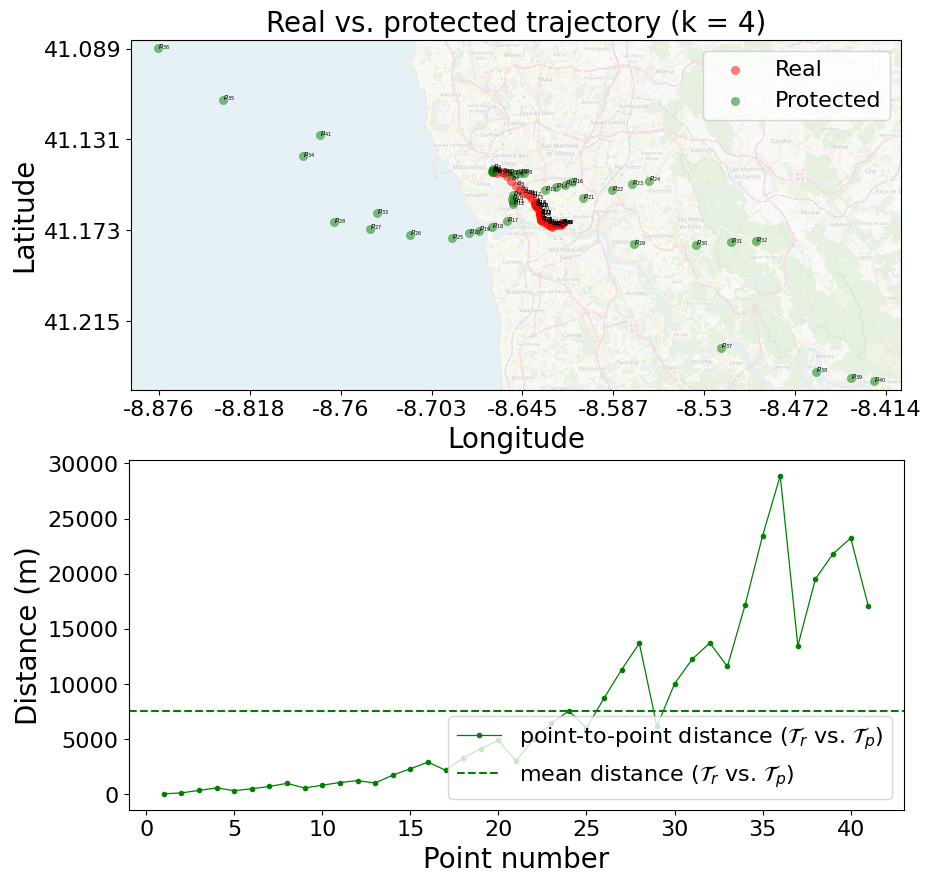

Point-to-point distance between the real and protected trajectory:
[np.float64(47.9700227941053), np.float64(130.64603067712085), np.float64(354.6063330768428), np.float64(590.6914239994002), np.float64(329.0190187245313), np.float64(512.0954894683532), np.float64(714.5176004504316), np.float64(998.3548985260658), np.float64(574.4853212289162), np.float64(832.4863252679784), np.float64(1070.072094892969), np.float64(1243.0891945196684), np.float64(1028.1472209671908), np.float64(1736.893613187564), np.float64(2317.3311912869194), np.float64(2919.9121779915654), np.float64(2179.9583859810873), np.float64(3285.388139207509), np.float64(4142.059900148909), np.float64(4898.7153848886655), np.float64(3022.0470751670414), np.float64(5009.660289118301), np.float64(6431.526279661318), np.float64(7558.782878631088), np.float64(6001.004573761064), np.float64(8733.358486371935), np.float64(11316.057212745622), np.float64(13691.065677151923), np.float64(6169.64528303893), np.float64(10020.21855329

In [ ]:
# PLOTS for K experiments.

traj_id = 5

# Create deep copy Y_pred to avoid overwriting the original data
Y_test_cp = copy.deepcopy(Y_t)

# Denormalize the data
normalization_ranges = {"min": mins[0:NUM_OUTPUTS], "max": maxs[0:NUM_OUTPUTS]}
Y_test_dn = denormalize_data(dataset=Y_test_cp, normalization_ranges=normalization_ranges)

# Get the trajectory traj_id
actual = Y_test_dn[traj_id]

for i in range(1, 5):
    
    actuals = Y_t
    preds = Y_PREDS_Ks[i]

    # Create deep copy Y_pred to avoid overwriting the original data
    Y_pred_cp = copy.deepcopy(preds)
    
    # Denormalize the data
    Y_pred_dn = denormalize_data(dataset=Y_pred_cp, normalization_ranges=normalization_ranges)
    # print(Y_pred_dn)
    
    # Get the predicted trajectory traj_id
    predicted = Y_pred_dn[traj_id]

    # Compute the point-to-point distance between the real and protected trajectory
    dists = compute_point_to_point_haversine_distances(actual, predicted)

    lons_min_ext, lons_max_ext, lats_min_ext, lats_max_ext = plot_trajectory(real_traj = actual,
                protected_traj = predicted,
                dists = dists,
                save=True, 
                aspect_ratio=2.2,
                k=i)
    
    print("Point-to-point distance between the real and protected trajectory:")
    print (dists)
    print("Min/max longitudes and latitudes of the trajectories:")
    print(lons_min_ext, lons_max_ext, lats_min_ext, lats_max_ext)
    print("##################################")
    print("Mean distance between the real and protected trajectory (MDE_k):")
    print(np.mean(dists))
    print("##################################")

#### **Load Test Data and the Model (San Francisco dataset)** 

In [2]:
# Load the model generated by the training script from the 'training' folder
selected_dataset = "SANFRANCISCO"

subset = "test" # or "train" 

# Load trajectory data for faster execution
data = load_data_from_pickle(DATASET[selected_dataset], TOTAL_TRAJS)

# Get the data in the selected square
data = get_data_in_square(data = data, square = DATA_SQUARE[selected_dataset])

# Get trajectories min and max values
mins, maxs =  get_min_max_from_data(data)

# Normalize the data using the min and max values
normalization_ranges = {"min": mins, "max": maxs}

# Get number of trajectories
num_of_traj = len(data)

# Only keep the lat and lon columns for now
data = [data[i][COLUMNS] for i in range(num_of_traj)]

# Normalize the data using scaler or normalization ranges
scaler, data = normalize_trajectory_data(dataset = data, normalization_type = 'min-max')

# Load the test data
X_t = load_pickle(DATA_FOLDER + selected_dataset.lower() + "_X_"+subset+".pkl") # the input trajectory data
Y_t = load_pickle(DATA_FOLDER + selected_dataset.lower() + "_Y_"+subset+".pkl") # the true values of the trajectory data
traj_seq_lengths = load_pickle(DATA_FOLDER + selected_dataset.lower() + "_seq_len_"+subset+".pkl") # the sequence lenght of the input trajectory data

# Save the model
mdl = load_pickle(MODEL_FOLDER + "mdlgru-"+selected_dataset.lower()+".pkl")

# Model for BS = 1
model_sl = create_GRU_model(GRU_cells= LSTM_CELLS,
                          seq_len = 1,
                          num_feat = NUM_FEATS,
                          batch_size = 1,
                          stateful = True,
                          return_seq = RETURN_SEQ,
                          num_outputs = NUM_OUTPUTS,
                          LR = LR,
                          SEED = SEED,
                          ragged = False)


# Set weights and states
model_sl.set_weights(mdl.get_weights())


#### **Experiment 2 (SanFrancisco dataset) - Fixed k-** 

In [ ]:
# Test Fixed K
n_trajs = 10

Y_PREDS_Ks = {}

save_pickle(Y_t[:n_trajs], DATA_FOLDER + selected_dataset.lower() + "_Y_test_fixed_k_ntrajs_" + str(n_trajs) + ".pkl")
save_pickle(traj_seq_lengths[:n_trajs], DATA_FOLDER + selected_dataset.lower() + "_test_seq_len_fixed_k_ntrajs_" + str(n_trajs) + ".pkl")

for k in range(1, 6):
    print("Generating trajectories with k = " + str(k))
    
    # Generate the trajectories using the APU Trajectory Generator with fixed k
    # The function apu_trajgen_fixed_k generates trajectories with a fixed k value
    # It uses the model_sl, input trajectory data X_t, sequence lengths traj_seq_lengths,
    # and other parameters to generate the trajectories.
    Y_pred_k = apu_trajgen_fixed_k(mdl = model_sl,
                                X_t = copy.deepcopy(X_t)[:n_trajs],
                                test_traj_seq_lengths = traj_seq_lengths,
                                SEQ_LENGTH = 1,
                                NUM_FEATS = NUM_FEATS,
                                k_steps=k)
    
    
    # Save the generated trajectories
    save_pickle(Y_pred_k, DATA_FOLDER + selected_dataset.lower() + "_Y_pred_fixed_k_" + str(k) + "_ntrajs_" + str(n_trajs) + ".pkl")
    
    Y_PREDS_Ks[k] = Y_pred_k

Generating trajectories with k = 1
Processing trajectory: 0
Processing trajectory: 1
Processing trajectory: 2
Processing trajectory: 3
Processing trajectory: 4
Processing trajectory: 5
Processing trajectory: 6
Processing trajectory: 7
Processing trajectory: 8
Processing trajectory: 9
Generating trajectories with k = 2
Processing trajectory: 0
Processing trajectory: 1
Processing trajectory: 2
Processing trajectory: 3
Processing trajectory: 4
Processing trajectory: 5
Processing trajectory: 6
Processing trajectory: 7
Processing trajectory: 8
Processing trajectory: 9
Generating trajectories with k = 3
Processing trajectory: 0
Processing trajectory: 1
Processing trajectory: 2
Processing trajectory: 3
Processing trajectory: 4
Processing trajectory: 5
Processing trajectory: 6
Processing trajectory: 7
Processing trajectory: 8
Processing trajectory: 9
Generating trajectories with k = 4
Processing trajectory: 0
Processing trajectory: 1
Processing trajectory: 2
Processing trajectory: 3
Processing

#### **Plot a Trajectory** 

<Figure size 640x480 with 0 Axes>

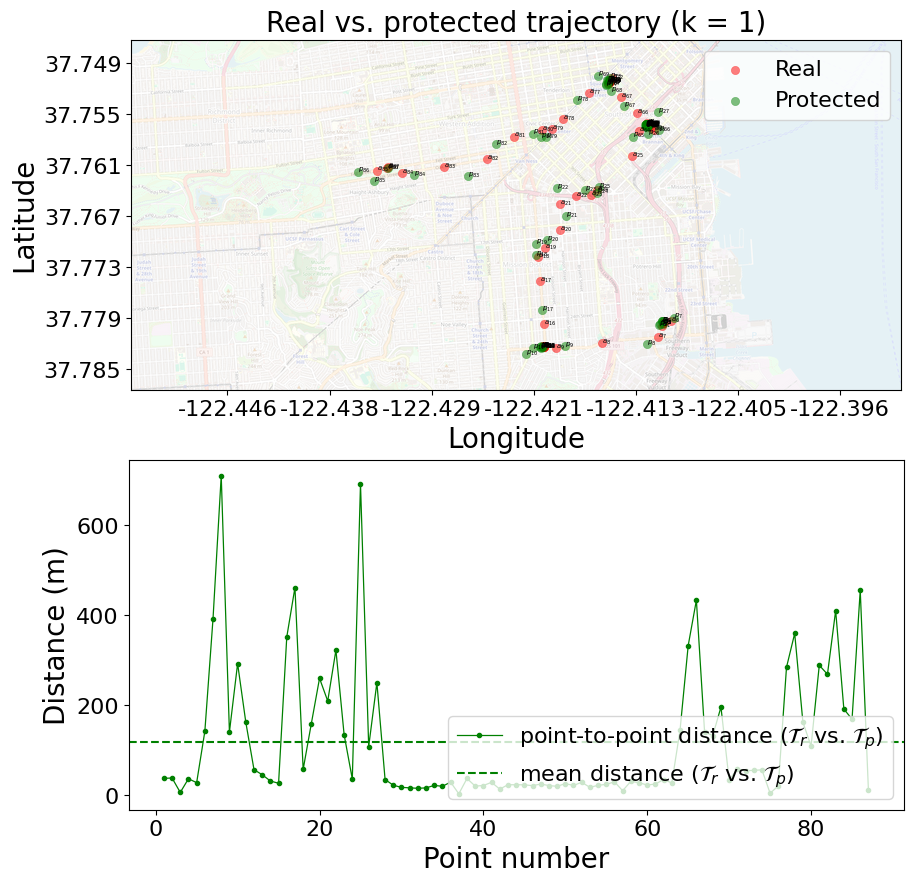

Point-to-point distance between the real and protected trajectory:
[np.float64(37.179122531416645), np.float64(38.00703626205893), np.float64(5.914729952583004), np.float64(36.3447449116199), np.float64(27.65542835951648), np.float64(141.7736373123725), np.float64(392.8581500847696), np.float64(710.7909950825073), np.float64(140.2469474949533), np.float64(292.6011078309213), np.float64(162.17320399485442), np.float64(56.62924070618762), np.float64(45.27235633786081), np.float64(31.336261320404553), np.float64(26.235551659007974), np.float64(351.66626447244676), np.float64(461.87332211871876), np.float64(57.01092422097044), np.float64(159.1782404130916), np.float64(259.86139210713935), np.float64(209.2523039193024), np.float64(322.6035668202917), np.float64(134.642960110511), np.float64(35.709675999342124), np.float64(692.2919108934741), np.float64(107.91659202731127), np.float64(250.11407767840066), np.float64(34.6526133680575), np.float64(21.952608506694308), np.float64(17.15870918621

<Figure size 640x480 with 0 Axes>

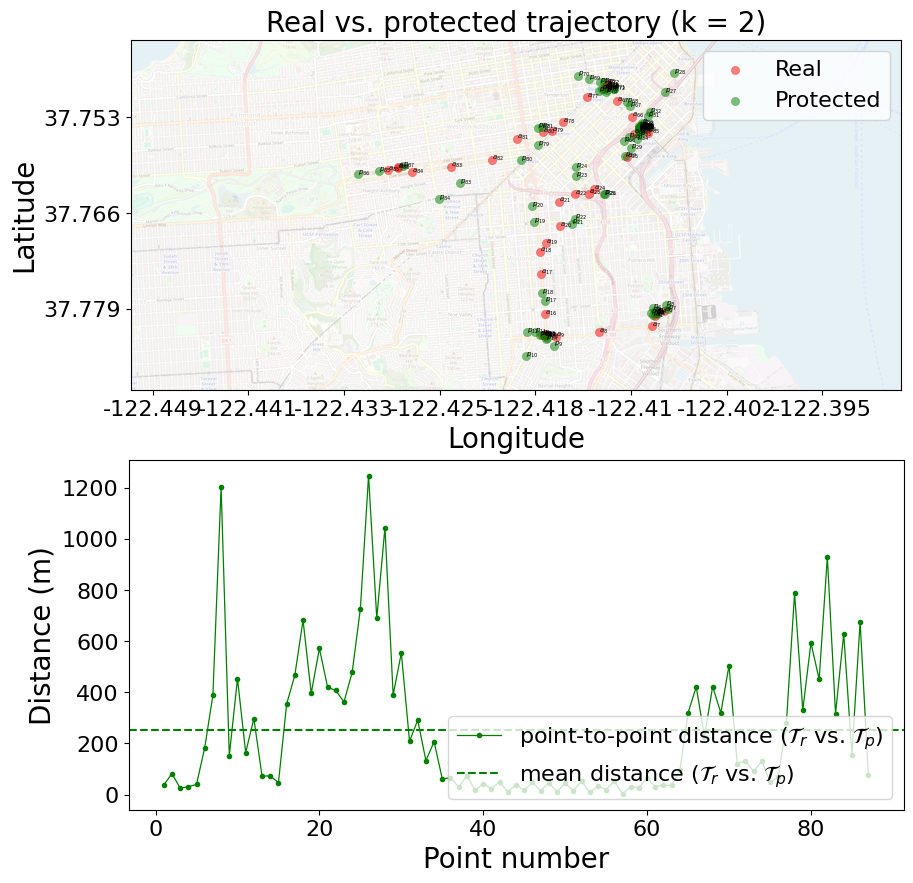

Point-to-point distance between the real and protected trajectory:
[np.float64(37.179122531416645), np.float64(81.70917655457563), np.float64(25.433924850250715), np.float64(30.583528760052058), np.float64(39.64517152830356), np.float64(182.88770941444685), np.float64(388.96532553602594), np.float64(1203.5233704192572), np.float64(152.11712295684683), np.float64(452.9078437289431), np.float64(164.13864457969177), np.float64(296.7821669945978), np.float64(71.84347411918758), np.float64(73.02385277888034), np.float64(46.51576526843604), np.float64(354.1103868903285), np.float64(466.4087752927064), np.float64(681.7355246608652), np.float64(395.52434185707153), np.float64(571.2721597352197), np.float64(420.00277059397644), np.float64(406.73800792133324), np.float64(362.19556201487393), np.float64(478.2588857339862), np.float64(726.4297784934879), np.float64(1246.7678592771024), np.float64(689.2468940493569), np.float64(1043.5380185660758), np.float64(388.7481894144819), np.float64(554.0259

<Figure size 640x480 with 0 Axes>

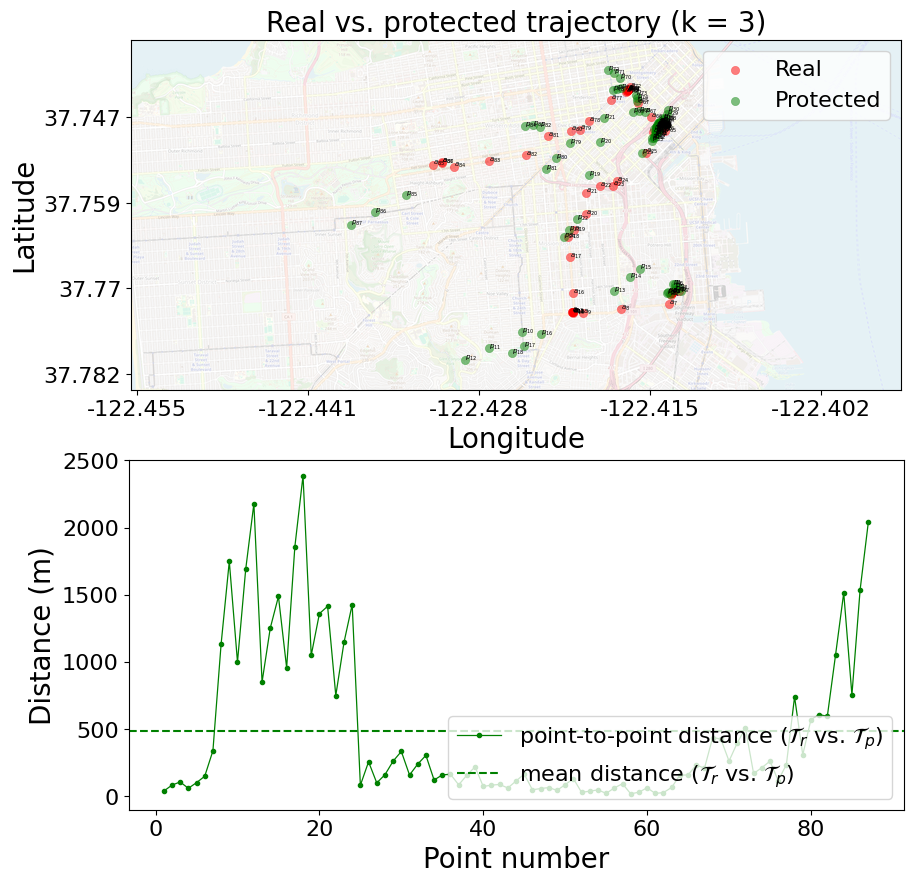

Point-to-point distance between the real and protected trajectory:
[np.float64(37.179122531416645), np.float64(81.70917655457563), np.float64(105.40129029913051), np.float64(58.27501924003527), np.float64(100.19296699696142), np.float64(147.87620361091388), np.float64(337.35475144653793), np.float64(1131.9009434376842), np.float64(1748.3920983381006), np.float64(998.7523605375638), np.float64(1687.9515599218641), np.float64(2177.2701674363684), np.float64(849.9182950323662), np.float64(1251.0822695082427), np.float64(1487.0569903636542), np.float64(955.917649429511), np.float64(1855.8275667908727), np.float64(2386.9605712209845), np.float64(1048.8052056593515), np.float64(1359.0610588440588), np.float64(1413.8041413932033), np.float64(749.1470111645043), np.float64(1144.7957635018968), np.float64(1426.4818585686833), np.float64(80.86309352802398), np.float64(255.55404018590164), np.float64(98.53793147292163), np.float64(159.1703385258483), np.float64(260.69956471438564), np.float64(332

<Figure size 640x480 with 0 Axes>

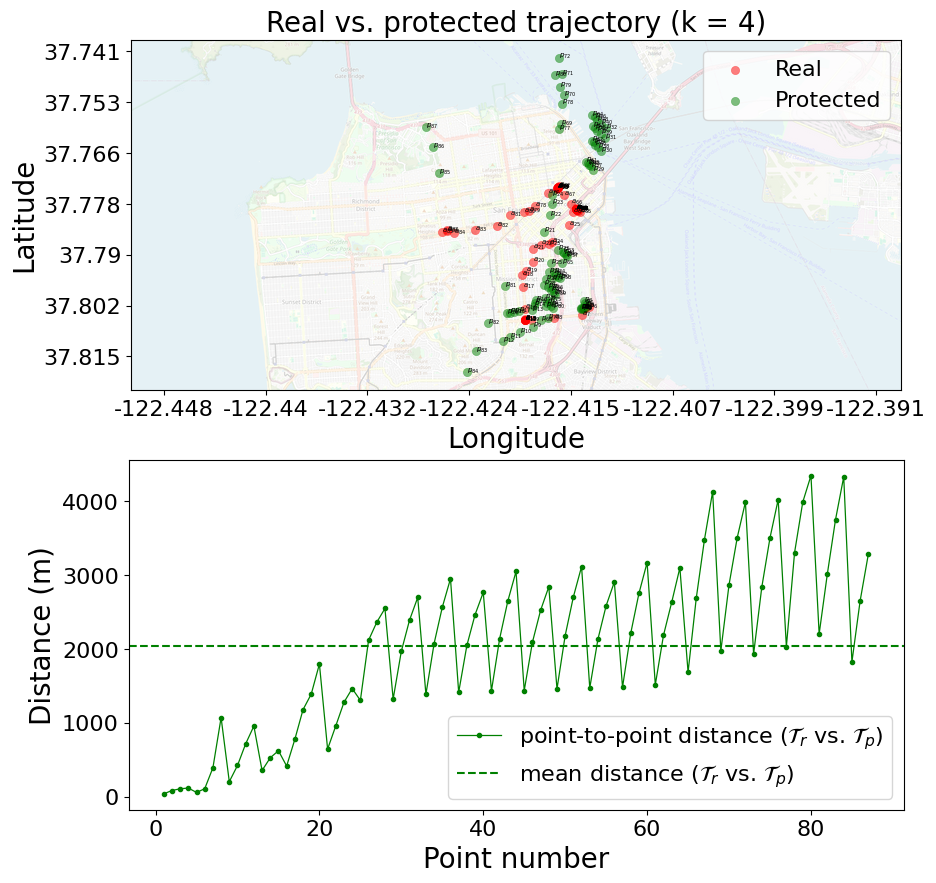

Point-to-point distance between the real and protected trajectory:
[np.float64(37.179122531416645), np.float64(81.70917655457563), np.float64(105.40129029913051), np.float64(115.345072136514), np.float64(55.773621777154915), np.float64(106.31286995781993), np.float64(389.45441999331905), np.float64(1069.545632123331), np.float64(201.67363328247134), np.float64(420.95671502128494), np.float64(714.9532683365476), np.float64(954.9070135138306), np.float64(353.20962077053815), np.float64(525.4166708660019), np.float64(621.1166533360476), np.float64(413.49848718572133), np.float64(775.0691410154874), np.float64(1177.6190610901817), np.float64(1387.6970595980392), np.float64(1795.9082831333635), np.float64(643.2029162185306), np.float64(958.3048781997707), np.float64(1277.2718253028838), np.float64(1463.1575943700357), np.float64(1303.323776337123), np.float64(2117.657877002477), np.float64(2361.6743080159154), np.float64(2548.272797670643), np.float64(1320.8302203280898), np.float64(1968.71

In [5]:
# PLOTS for K experiments.
traj_id = 8

# Create deep copy Y_pred to avoid overwriting the original data
Y_test_cp = copy.deepcopy(Y_t)

# Denormalize the data
normalization_ranges = {"min": mins[0:NUM_OUTPUTS], "max": maxs[0:NUM_OUTPUTS]}
Y_test_dn = denormalize_data(dataset=Y_test_cp, normalization_ranges=normalization_ranges)

# Get the trajectory traj_id
actual = Y_test_dn[traj_id]

for i in range(1, 5):
    
    actuals = Y_t
    preds = Y_PREDS_Ks[i]

    # Create deep copy Y_pred to avoid overwriting the original data
    Y_pred_cp = copy.deepcopy(preds)
    
    # Denormalize the data
    Y_pred_dn = denormalize_data(dataset=Y_pred_cp, normalization_ranges=normalization_ranges)
    
    # Get the predicted trajectory traj_id
    predicted = Y_pred_dn[traj_id]

    # Compute the point-to-point distance between the real and protected trajectory
    dists = compute_point_to_point_haversine_distances(actual, predicted)
    
    # Plot the trajectories
    lons_min_ext, lons_max_ext, lats_min_ext, lats_max_ext = plot_trajectory(real_traj = actual,
                protected_traj = predicted,
                dists = dists,
                save=True, 
                aspect_ratio=2.2,
                k=i)
    
    print("Point-to-point distance between the real and protected trajectory:")
    print (dists)
    print("Min/max longitudes and latitudes of the trajectories:")
    print(lons_min_ext, lons_max_ext, lats_min_ext, lats_max_ext)
    print("##################################")
    print("Mean distance between the real and protected trajectory (MDE_k):")
    print(np.mean(dists))
    print("##################################")